# Comparison of DFT and FFT
In this Jupyter notebook I compare different algorithms to obtain the Discrete Fourier Transform.

First import the numpy stuff:

In [1]:
import numpy as np
from numpy import exp, pi

Below is a naive/brute force implementation of the DFT:

In [2]:
def DFT_brute_force(signal, inverse=False):
    """
    Computes the DFT in a naive way
    Input: 
        signal    1d-numpy array
                  signal
        inverse   bool (OPTIONAL)
                  if true, compute the inverse DFT
    Returns:
        transformed  1d-numpy array
                  Fourier Transform of the signal
                
    """
    n = len(signal)
    transformed = np.zeros(signal.shape, dtype=complex)
    for k in range(n): # for each transformed element
        for l in range(n): # compute sum in loop
            if not inverse:
                transformed[k] += signal[l] * exp(-2j * pi * k * l / n)
            else: 
                transformed[k] += signal[l] * exp(2j * pi * k * l / n)
    return transformed

It is a bit more efficient to solve the DFT with a single matrix-vector-multiplication

In [3]:
def DFT(signal, inverse=False):
    """
    Computes the DFT by a matrix-vector-multiplication
    Input: 
        signal    1d-numpy array
                  signal
        inverse   bool (OPTIONAL)
                  if true, compute the inverse DFT
    Returns:
        transformed  1d-numpy array
                  Fourier Transform of the signal
                
    """
    n = len(signal)
    k_array = np.arange(n)
    if not inverse:
        W = exp(-2j * pi * np.outer(k_array, k_array) / n) # DFT matrix
    else:
        W = exp(2j * pi * np.outer(k_array, k_array) / n) # inverse DFT matrix
    return W.dot(signal) # matrix vector product

This recursive FFT algorithm enables a better time complexity when obtaining the Discrete Fourier Transform of a signal:

In [4]:
def FFT(signal, cutoff=16, w=None):
    """
    Computes the FFT with a recursive implementation of the Cooley-Tukey algorithm
    Inputs:
        signal     1d-numpy array
                   signal of length 2**x, type(x)=int
        cutoff     int, OPTIONAL 2**x
                   size of the 'lowest split level' to compute the DFT on
    Returns:
        output     1d-numpy array
                   FFT of the signal
    """
    n = len(signal)
    if (n == 1): # trivial case
        return signal
    if (n <= cutoff): # cutoff with DFT
        return DFT(signal)
    output = np.zeros(n, dtype=complex)
    m = int(n/2)
    signal = signal.reshape(m, 2) # split signal in even, odd
    even, odd = signal[:,0], signal[:,1]
    if w is None: # compute twiddle factors if not given
        w = np.exp(-2j * np.pi * np.arange(m) / n)
    else:
        w = w[0:n-1:2] # reuse twiddle factors
    e = FFT(even, cutoff, w)     # even FFT
    o = w * FFT(odd, cutoff, w)  # odd FFT
    output[:m] = e + o
    output[m:] = e - o
    return output

Just some test function to validate the implementations:

In [5]:
import timeit
import statistics
def test(func, n=2**8, samples=10):
    """
    Test function
    """
    data = np.random.randint(-10, 10, size=n) + 1j*np.random.randint(-10, 10, size=n)
    compare = np.fft.fft(data) - func(data)
    if max(abs(compare)) > 1e-6:
        print('Implementation wrong!')
        return
    f = lambda: func(data)
    times = timeit.Timer(f).repeat(samples, 1)
    mean = statistics.mean(times)
    return mean

Execution times for the different algorithms with data size n=256:

In [6]:
test(DFT_brute_force)

0.18612640809997175

In [7]:
test(DFT)

0.07806640300013896

In [8]:
test(FFT)

0.0015253960999871198

Test function to run benchmarks for different FFT implementations:

*You have to reduce the data sizes, if your computer is rather slow!*

In [9]:
import math
import matplotlib.pyplot as plt
from IPython.display import HTML, display
#import tabulate
%matplotlib notebook
def testCycle(funcs, start=2**1, end=2**8, samples=10, verbose=False):
    n = start
    iterations = []
    times = [[] for f in funcs]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    while n <= end:
        row = []
        iterations.append(n)
        if verbose:
            ax.clear()
            plt.xscale("log", base=2)
            plt.yscale("log")
        for i, func in enumerate(funcs):
            time = test(func, n, samples)
            if time < 1e-3:
                time = test(func, n, int(samples/math.sqrt(time)))
            times[i].append(time)
            row.append(str(time))
            if verbose:
                ax.plot(iterations, times[i], label=func.__name__)
                ax.legend()
        if verbose:
            fig.canvas.draw()
        print(n, '|', ' | '.join(row))
        n *= 2
    #for i, func in enumerate(funcs):
    #    plt.plot(iterations, times[i])
    #plt.xscale("log", basex=2)
    #plt.yscale("log")
    return times

Compare brute force DFT, DFT and FFT:

<IPython.core.display.Javascript object>


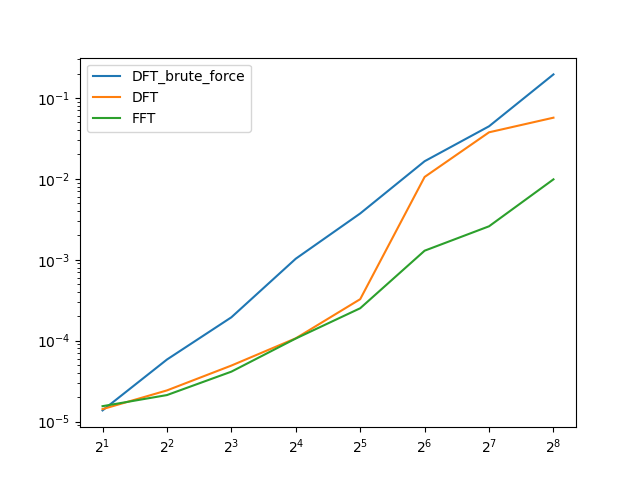

2 | 1.3737992373344857e-05 | 1.4250105801844346e-05 | 1.5495576307045414e-05
4 | 5.842949711584605e-05 | 2.4265896438414025e-05 | 2.12529348049927e-05
8 | 0.00019435455010388745 | 4.9204957769554176e-05 | 4.1378795041081e-05
16 | 0.0010298796998540638 | 0.00010690422604208531 | 0.00010627813267739159
32 | 0.0037299766999240092 | 0.0003254725202270896 | 0.0002514274488704176
64 | 0.0164880895998067 | 0.010542080599952897 | 0.0012928301998726965
128 | 0.04456514660005269 | 0.037549819000105344 | 0.002588714700232231
256 | 0.19505571320005402 | 0.056914974400297066 | 0.00984482530002424


In [11]:
testCycle((DFT_brute_force, DFT, FFT), verbose=True);

Compare DFT, FFT and NumPy fft:

<IPython.core.display.Javascript object>


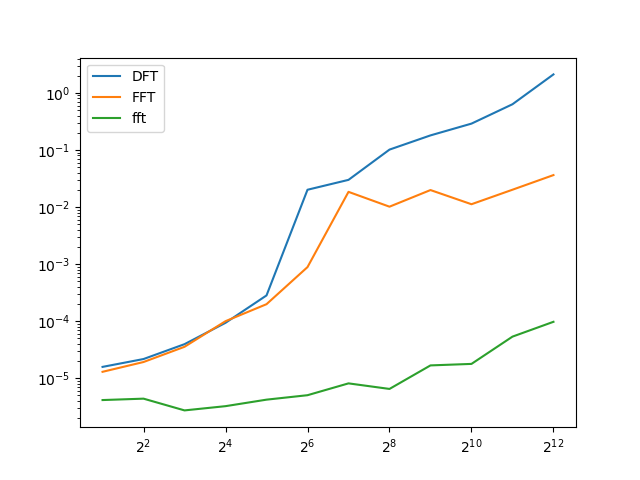

2 | 1.5825205945031524e-05 | 1.2972535086844593e-05 | 4.150955152229255e-06
4 | 2.17244314439585e-05 | 1.925983250491967e-05 | 4.392520028305196e-06
8 | 3.9578300499494306e-05 | 3.559650282218764e-05 | 2.7348287907032183e-06
16 | 9.361599776380066e-05 | 0.00010005754458866786 | 3.244973432306749e-06
32 | 0.00028263123344475456 | 0.0001985208700300152 | 4.219175975036748e-06
64 | 0.020080317200063293 | 0.0008865034613481839 | 5.0489265951657085e-06
128 | 0.029923764300201584 | 0.018447868999828643 | 8.136574814039472e-06
256 | 0.10142022219988575 | 0.010141720700084988 | 6.502083671475457e-06
512 | 0.1799668856999233 | 0.019838424399858924 | 1.6798034254908054e-05
1024 | 0.2893951239999296 | 0.011199943399969926 | 1.784682280439137e-05
2048 | 0.6321960016998673 | 0.02010306460015272 | 5.363048231131574e-05
4096 | 2.1078694592997635 | 0.03628625809997175 | 9.754033922392552e-05


In [13]:
testCycle([DFT, FFT, np.fft.fft], end=2**12, verbose=True);

Compare FFT and NumPy fft:

<IPython.core.display.Javascript object>


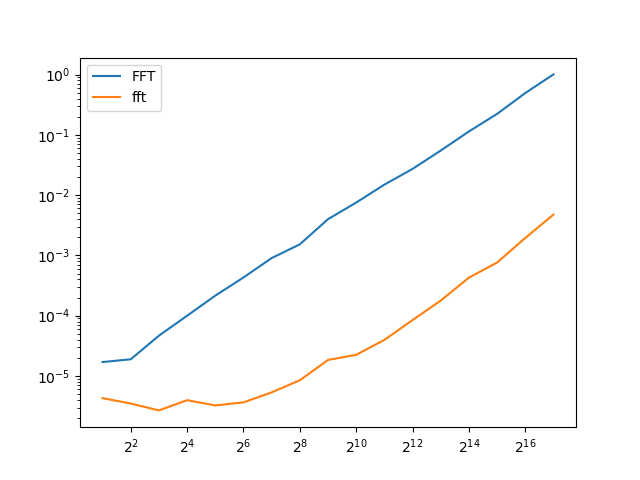

2 | 1.700480477063414e-05 | 4.285684286284892e-06
4 | 1.891269476368057e-05 | 3.4942459837547525e-06
8 | 4.6578233293246646e-05 | 2.686229133950917e-06
16 | 9.989064967449887e-05 | 3.969507472604626e-06
32 | 0.0002149209290976371 | 3.247614499582942e-06
64 | 0.00042991068736166074 | 3.647795663020152e-06
128 | 0.0009023012353001719 | 5.344617394974462e-06
256 | 0.0015241888000673497 | 8.495396437833137e-06
512 | 0.003986557299958804 | 1.8436969685289124e-05
1024 | 0.007515083999987837 | 2.2436052860534258e-05
2048 | 0.014920950500163599 | 3.966264305738788e-05
4096 | 0.027187338900057513 | 8.454933464418707e-05
8192 | 0.0547484636002082 | 0.0001778677923789641
16384 | 0.11362426230007258 | 0.0004273212283245205
32768 | 0.2223341140998855 | 0.0007614831013537089
65536 | 0.4926871380999728 | 0.0019459608000943263
131072 | 1.004262328200093 | 0.004753722100122104


In [14]:
testCycle([FFT, np.fft.fft], end=2**17, verbose=True);

Run NumPy fft with large data sizes:

<IPython.core.display.Javascript object>


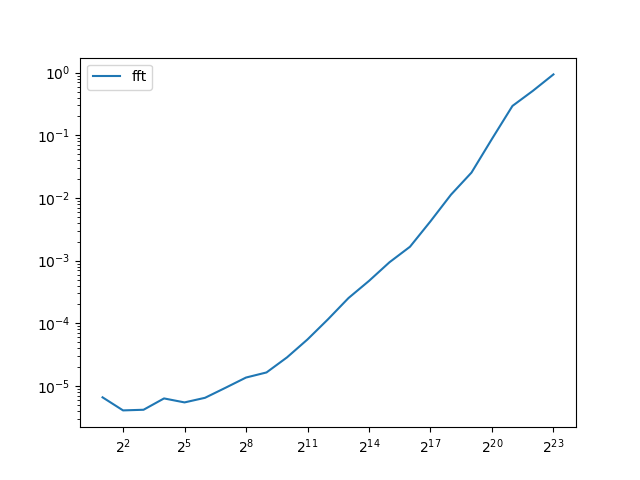

2 | 6.591297940305046e-06
4 | 4.0777760517501356e-06
8 | 4.174977580112834e-06
16 | 6.331706941510866e-06
32 | 5.46900703376245e-06
64 | 6.47922909661072e-06
128 | 9.36476554680087e-06
256 | 1.3635766047576952e-05
512 | 1.6448549963230957e-05
1024 | 2.8604059313814506e-05
2048 | 5.532196804851217e-05
4096 | 0.00011594983802651164
8192 | 0.0002531140660064218
16384 | 0.00047496696703998065
32768 | 0.0009427101865215845
65536 | 0.0016665442001794872
131072 | 0.004242526499911037
262144 | 0.011284021500250674
524288 | 0.02539380190000884
1048576 | 0.08757919020008557
2097152 | 0.29435732779993484
4194304 | 0.513730654900246
8388608 | 0.9372726870000406


In [15]:
testCycle([np.fft.fft], end=2**23, verbose=True);